<a href="https://colab.research.google.com/github/Symiooo/Symiooo/blob/main/Investment_Risk_Return_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NASDAQ Investing Model

Source:
- https://github.com/ritvikmath/Time-Series-Analysis/blob/master/Investing.ipynb
- https://www.codingfinance.com/post/2018-04-03-calc-returns-py/

Modell-Struktur:
- Baseline ist eine definierte Ticker-list, die über pd.datareader eingelesen & transformiert wird
- Im zweiten Schritt werden alle Ticker nacheinander durch Daten von yahoo.finance analysiert
- Wenn Ticker nicht in yahoo.finance verfügbar ist, dann Error-Meldung und zum nächsten Ticker springen
- Für jeden Ticker dataframe auf Aktienschlusskurs und Datum beschränken
- 2 Funktionen schreiben
- 1 Funktion erstellt Plots, für all diejenigen Ticker die, die min_avg_return übersteigen, bei geringerer Volatilität
- 1 Funktion führt Berechnungen für alle Ticker durch
- Berechnungen sind: 


In [ ]:
import pandas as pd
import pandas_datareader as pdr

# Get Ticker list
tickers = pdr.get_nasdaq_symbols()

# Exclude non-traded Nasdaq Securities and ETFs
filtered = tickers[(tickers["Nasdaq Traded"] == True) & (tickers["ETF"] == False)]

# Filter for Security Name that contain the string "Common Stock"
stocks = filtered[filtered["Security Name"].str.contains("Common Stock")]

# Keep only columns of interest, reindex & delete redundant symbol column
stocks = stocks[["NASDAQ Symbol", "Security Name"]].reset_index()
del stocks["Symbol"]

# Rename column names
stocks.columns = ["Ticker","Name"]

# Convert Tickers into strings
stocks["Ticker"] = stocks["Ticker"].astype(str)

stocks.head()


,Ticker,Name
0,A,"Agilent Technologies, Inc. Common Stock"
1,AA,Alcoa Corporation Common Stock
2,AADI,"Aadi Bioscience, Inc. - Common Stock"
3,AAL,"American Airlines Group, Inc. - Common Stock"
4,AAME,Atlantic American Corporation - Common Stock


## 01 Stock Analysis Function

-  [`.date()` explained](https://stackoverflow.com/questions/35262794/get-value-by-date)
- 



In [ ]:
def perform_analysis_for_stock(ticker, start_date, end_date, return_period_weeks, verbose=False):
    """
    Inputs:
        ticker: the ticker symbol to analyze
        start_date: the first date considered in simulation
        end_date: the last date considered in simulation
        return_period_weeks: the number of weeks in which to calculate returns
        verbose: True if you want to print simulation steps
        
    Outputs:
        average and standard deviation of returns for simulated runs of this ticker within the given date range
    """
    # Get Data
    price = yf.Ticker(ticker)
    ticker = price.history(start = start_date, end = end_date)["Close"]
    # Format index column as date type
    ticker.index = [datetime.date(d) for d in ticker.index]
    # ticker.index = [datetime.strftime(d, "%Y-%m-%d") for d in ticker.index]
    
    ticker = pd.DataFrame(ticker)
    ticker.columns = ["Price"]
    #print(ticker.info())
    
    # Create empty lists to store all simulated returns
    pct_return_after_period = []
    buy_dates = []
    
    #print(ticker.head())
    
    # Assume we buy the stock on each day in the range
    for buy_date, buy_price in ticker.iterrows():
      
      # Get price of the stock after given number of weeks
      sell_date = buy_date + timedelta(weeks=return_period_weeks)
      try:
        condition = ticker.index == sell_date
        sell_price = ticker[condition].Price.values[0]
        # Skip when trying to sell on a non-trading day
      except (IndexError, ValueError):
          continue
          
      # Compute the percent return
      pct_return = (sell_price - buy_price)/buy_price
      pct_return_after_period.append(pct_return)
      buy_dates.append(buy_date)
    
    #if no data collected return default values
    if len(pct_return_after_period) == 0:
      return -np.inf, np.inf, None
    
    #report average and deviation of the percent returns
    return np.mean(pct_return_after_period), np.std(pct_return_after_period), [buy_dates, pct_return_after_period]

## 02 Plot Function

In [ ]:
######################### Plot charts ######################################
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

def plot_stock_trend_and_returns(stock, titles, start_date, end_date, all_returns): 
  
  # Prepare Data: Close Price and Pct. Returns ##########################
  # Get historical prices of stock
  price = yf.Ticker(stock)
  ticker = price.history(start = start_date, end = end_date)["Close"]
  ticker = pd.DataFrame(ticker)
  # Calculate stock returns
  ticker["Returns"] = ticker["Close"].pct_change()
  returns = ticker.iloc[1:, 1]
  returns = pd.DataFrame(returns)
  # Define Title of Plots
  #stock_name = stocks.loc[stocks["Ticker"] == stock, "Name"].item()

  # Set figure subplot-size ##############################################
  plt.figure(figsize=(15,10))
  plt.style.use("fivethirtyeight")
  fig, ax = plt.subplots(2, 1, sharex = True, figsize = (15,10))
  
   # Plot stock price ####################################################
  ticker["Close"].plot(ax = ax[0], linewidth = 2)
  
  # Plot stock returns ###################################################
  ticker["Returns"].plot(ax = ax[1], color="g", linewidth = 2)
  plt.axhline(0, color="k", linestyle="--", linewidth = 2)

  # Set Axes Labels and Titles ###########################################
  ax[0].set_title("Stock price of " + str(stock_name), fontsize = 18)
  ax[0].set_xlabel("Date", fontsize = 16)
  ax[0].set_ylabel("Price ($)", fontsize = 16)
  ax[1].set_title(titles[1], fontsize = 18)
  ax[1].set_xlabel("Date", fontsize = 16)
  ax[1].set_ylabel("Pct. Return", fontsize = 16)

  plt.show()

## 03 Model Operationalized

### 03a User Input Defintion

In [ ]:
#start date for simulation. 
#Further back means more training data but risk of including patterns that no longer exist
#More recent means less training data but only using recent patterns

from datetime import date, datetime, timedelta
import numpy as np
import pandas as pd

# Define Start Date
start_date = date.today() - timedelta(days = 365)

# Define End Date
end_date = date.today()

#set number of weeks in which you want to see return
return_period_weeks = 8

#I want at least this much average return
min_avg_return  = 0.1

#I want at most this much volatility in return
max_dev_return = 0.07

print(start_date, end_date)

2020-09-04 2021-09-04


### 03b Import Tickers of Dow Jones, S&P 500 and NASDAQ

- http://theautomatic.net/yahoo_fin-documentation/
- https://levelup.gitconnected.com/how-to-get-all-stock-symbols-a73925c16a1b


In [ ]:
!pip install yahoo_fin

!pip install request_html

In [ ]:
from yahoo_fin import stock_info as si

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date, timedelta

In [ ]:
# Import S&P500 Tickers
sp500_df = pd.DataFrame(si.tickers_sp500())
print(sp500_df.shape)
# Import Nasdaq Tickers
nasdaq_df = pd.DataFrame(si.tickers_nasdaq())
print(nasdaq_df.shape)
#Import Dow Jones Tickers
dow_df = pd.DataFrame(si.tickers_dow())
print(dow_df.shape)

tickers_df = pd.concat([sp500_df, nasdaq_df, dow_df], axis = 0)
tickers = tickers_df[0].tolist()

tickers[:10]


(505, 1)
(4970, 1)
(30, 1)


['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE']

In [ ]:

si.get_earnings("AAPL", qu)

{'quarterly_results':      date  actual  estimate
 0  3Q2020    0.73      0.70
 1  4Q2020    1.68      1.41
 2  1Q2021    1.40      0.99
 3  2Q2021    1.30      1.01,
 'quarterly_revenue_earnings':      date       revenue     earnings
 0  3Q2020   64698000000  12673000000
 1  4Q2020  111439000000  28755000000
 2  1Q2021   89584000000  23630000000
 3  2Q2021   81434000000  21744000000,
 'yearly_revenue_earnings':    date       revenue     earnings
 0  2017  229234000000  48351000000
 1  2018  265595000000  59531000000
 2  2019  260174000000  55256000000
 3  2020  274515000000  57411000000}

In [ ]:
# Install yfinance package
!pip install yfinance

In [ ]:
# Load Packages
import pandas as pd
import pandas_datareader as pdr

import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from datetime import date, timedelta

In [ ]:
import pandas as pd
import pandas_datareader as pdr

# Get Ticker list
tickers = pdr.get_nasdaq_symbols()

# Exclude non-traded Nasdaq Securities and ETFs
filtered = tickers[(tickers["Nasdaq Traded"] == True) & (tickers["ETF"] == False)]

# Filter for Security Name that contain the string "Common Stock"
stocks = filtered[filtered["Security Name"].str.contains("Common Stock")]

# Keep only columns of interest, reindex & delete redundant symbol column
stocks = stocks[["NASDAQ Symbol", "Security Name"]].reset_index()
del stocks["Symbol"]

# Rename column names
stocks.columns = ["Ticker","Name"]

# Convert Tickers into strings
stocks["Ticker"] = stocks["Ticker"].astype(str)

stocks.head()

,Ticker,Name
0,A,"Agilent Technologies, Inc. Common Stock"
1,AA,Alcoa Corporation Common Stock
2,AADI,"Aadi Bioscience, Inc. - Common Stock"
3,AAL,"American Airlines Group, Inc. - Common Stock"
4,AAME,Atlantic American Corporation - Common Stock


In [ ]:
nasdaq_list = stocks["Ticker"].tolist()

nasdaq_list[:10]

['A', 'AA', 'AADI', 'AAL', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAPL', 'AAQC']

### 03c Automated Risk-Return-Analysis

- ACRO=: No data found, symbol may be delisted
- ADRA+: No data found, symbol may be delisted
- AGM.A: No data found, symbol may be delisted
- AKO.A: No data found, symbol may be delisted
- AKO.B: No data found, symbol may be delisted
- ALIT+: No data found, symbol may be delisted
- AMPI+: No data found, symbol may be delisted
- ATEST.A: No data found, symbol may be delisted
- ATEST.B: No data found, symbol may be delisted
- ATEST.C: No data found, symbol may be delisted
- ATHN=: No data found, symbol may be delisted
- ATHN+: No data found, symbol may be delisted
- BF.A: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- BH.A: No data found, symbol may be delisted
- BIO.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- BRMK+: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

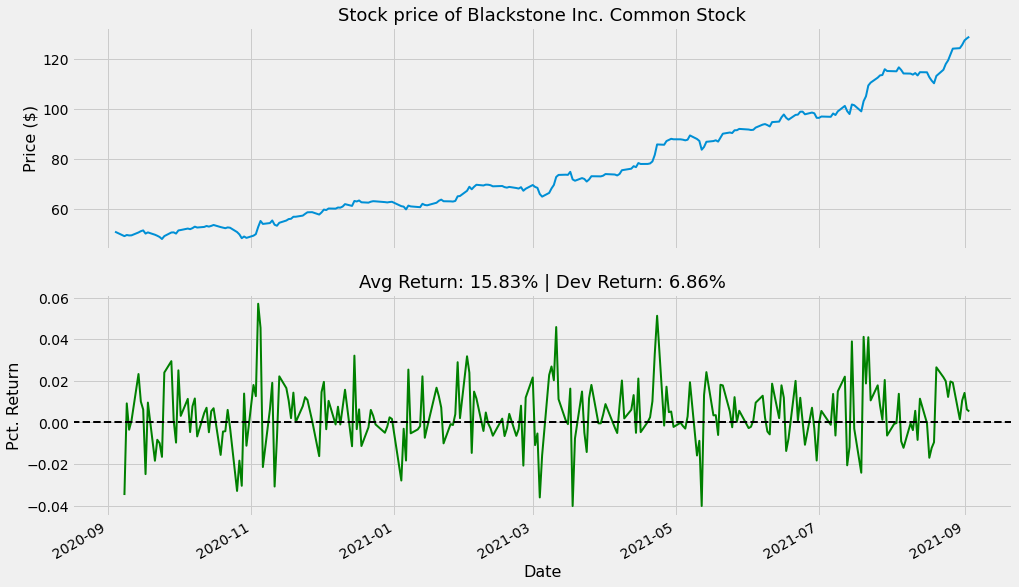

- CAS=: No data found, symbol may be delisted
- CAS+: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

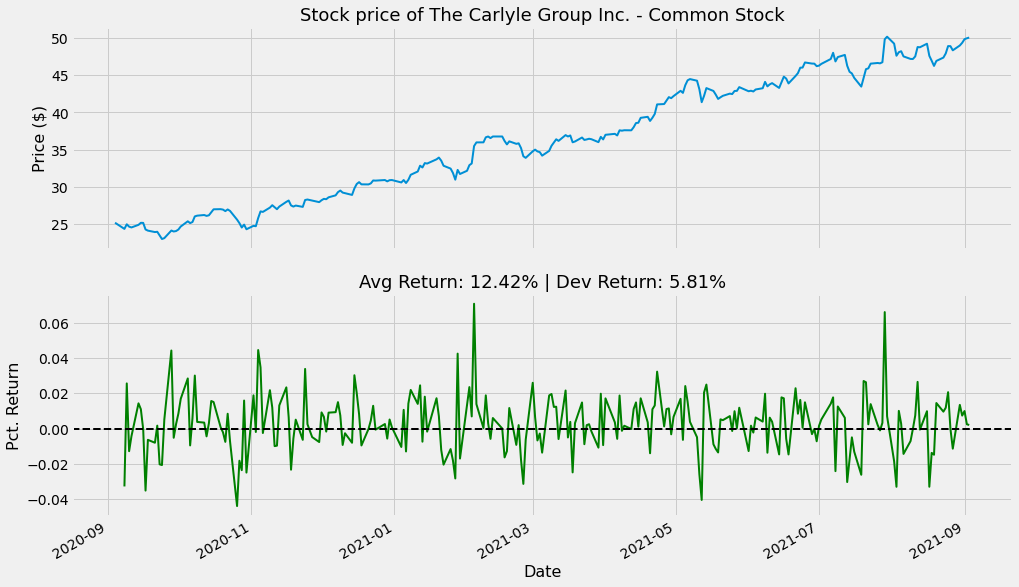

- CLAS+: No data found, symbol may be delisted
- CLIM+: No data found, symbol may be delisted
- CND=: No data found, symbol may be delisted
- CND+: No data found, symbol may be delisted
- CPSR=: No data found, symbol may be delisted
- CPSR+: No data found, symbol may be delisted
- CRD.A: No data found, symbol may be delisted
- CRD.B: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

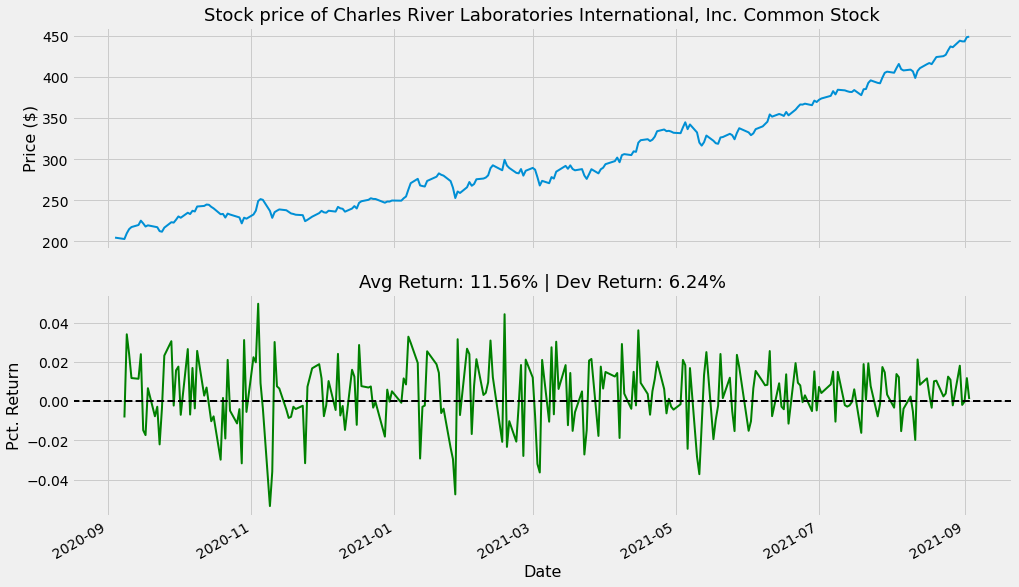

- CTEST.E: No data found, symbol may be delisted
- CTEST.G: No data found, symbol may be delisted
- CTEST.L: No data found, symbol may be delisted
- CTEST.O: No data found, symbol may be delisted
- CTEST.S: No data found, symbol may be delisted
- CTEST.V: No data found, symbol may be delisted
- CWEN.A: No data found, symbol may be delisted
- DNZ=: No data found, symbol may be delisted
- DNZ+: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

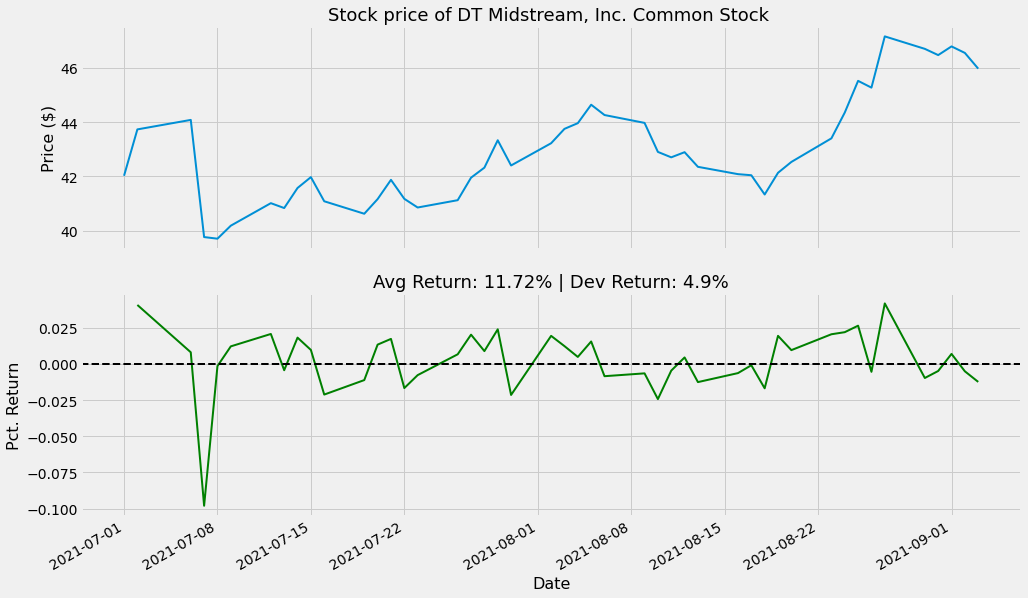

- DWIN+: No data found, symbol may be delisted
- EQHA+: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

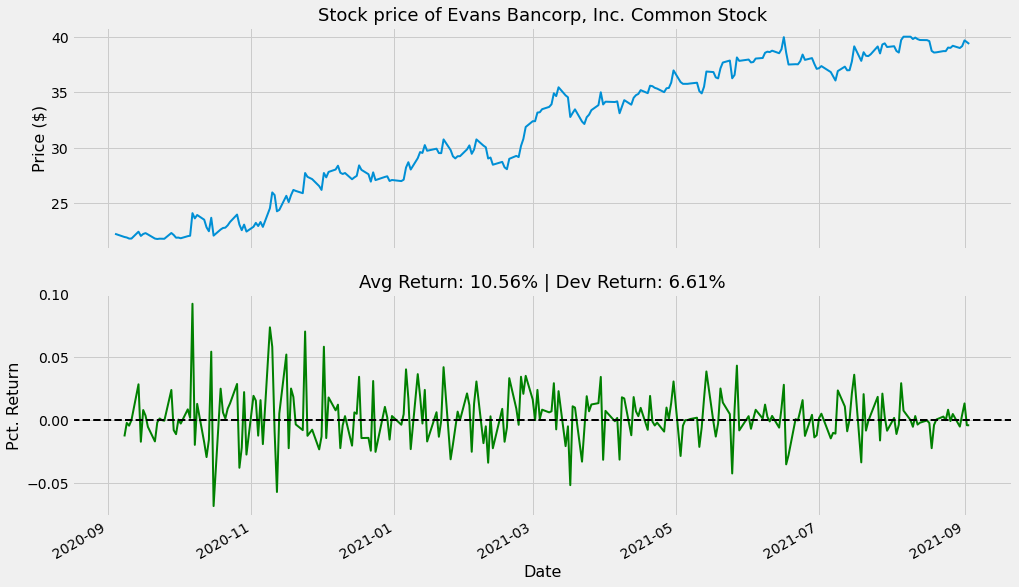

<Figure size 1080x720 with 0 Axes>

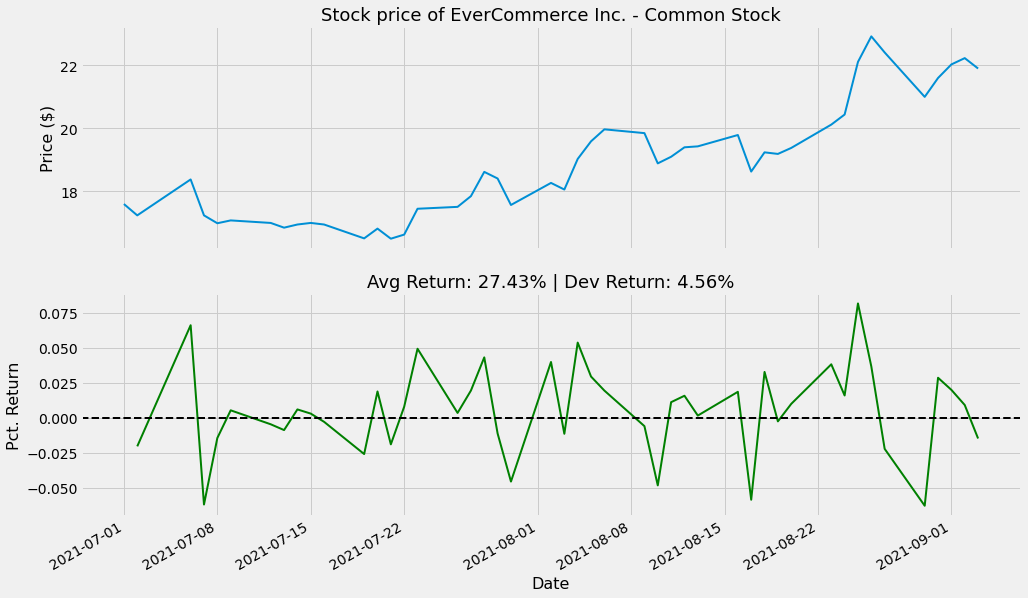

<Figure size 1080x720 with 0 Axes>

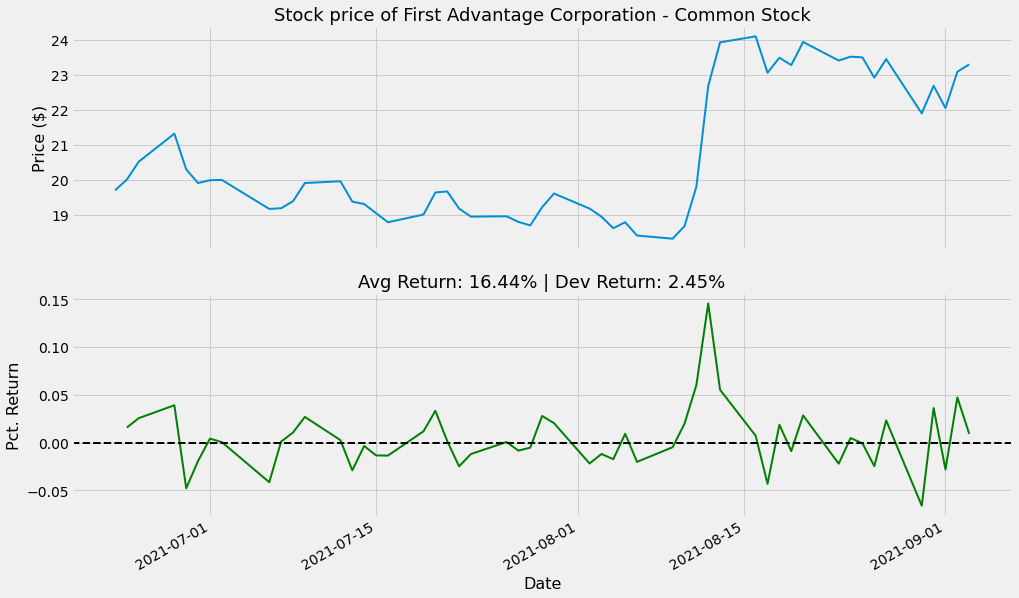

- FLME=: No data found, symbol may be delisted
- FLME+: No data found, symbol may be delisted
- FOA+: No data found, symbol may be delisted
- FRXB+: No data found, symbol may be delisted
- FST+: No data found, symbol may be delisted
- FUSE=: No data found, symbol may be delisted
- GEF.B: No data found for this date range, symbol may be delisted
- GFX=: No data found, symbol may be delisted
- GFX+: No data found, symbol may be delisted
- GLTA=: No data found, symbol may be delisted
- GOAC=: No data found, symbol may be delisted
- GOAC+: No data found, symbol may be delisted
- GOED+: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

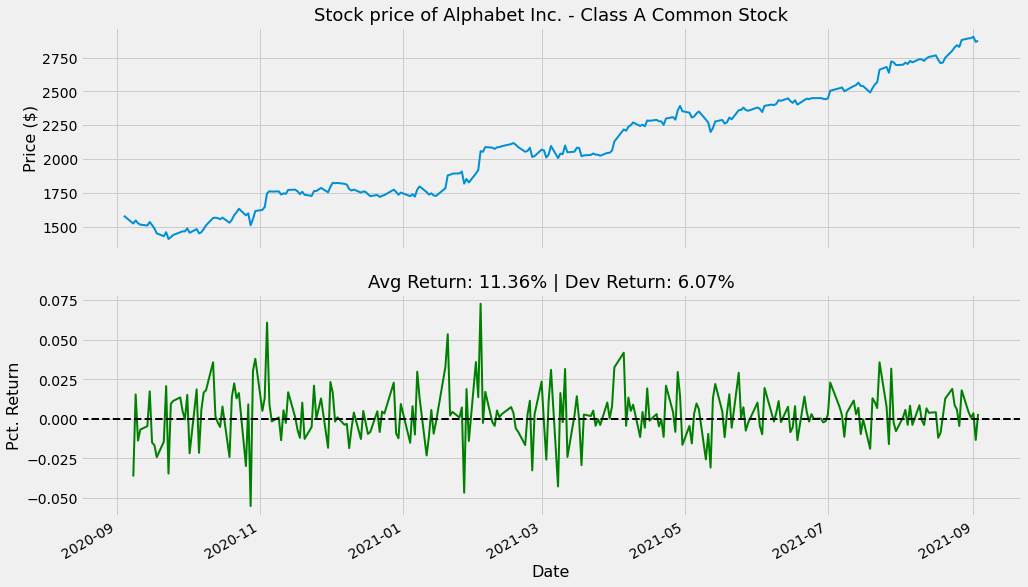

<Figure size 1080x720 with 0 Axes>

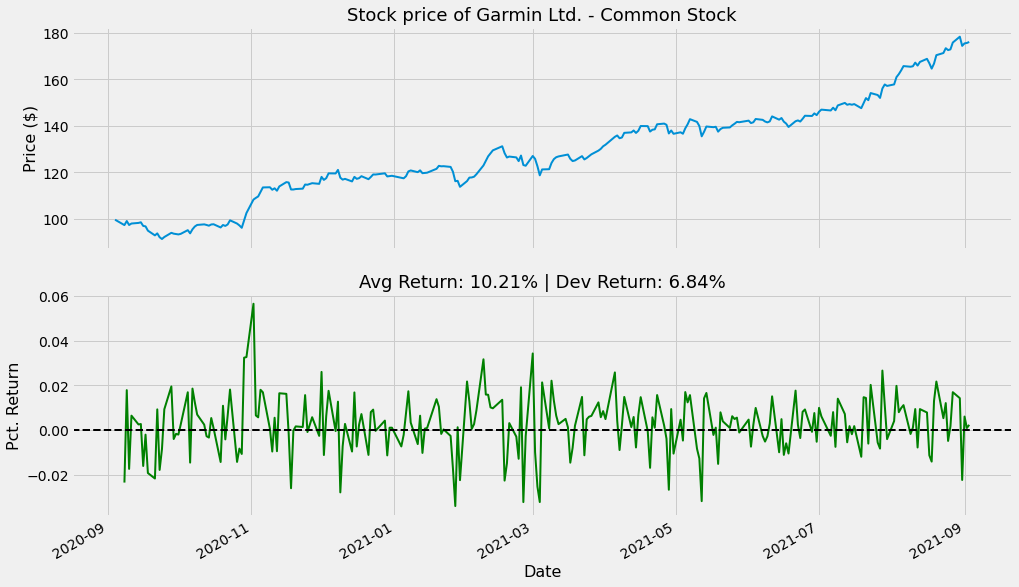

- GSAH=: No data found, symbol may be delisted
- GTN.A: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

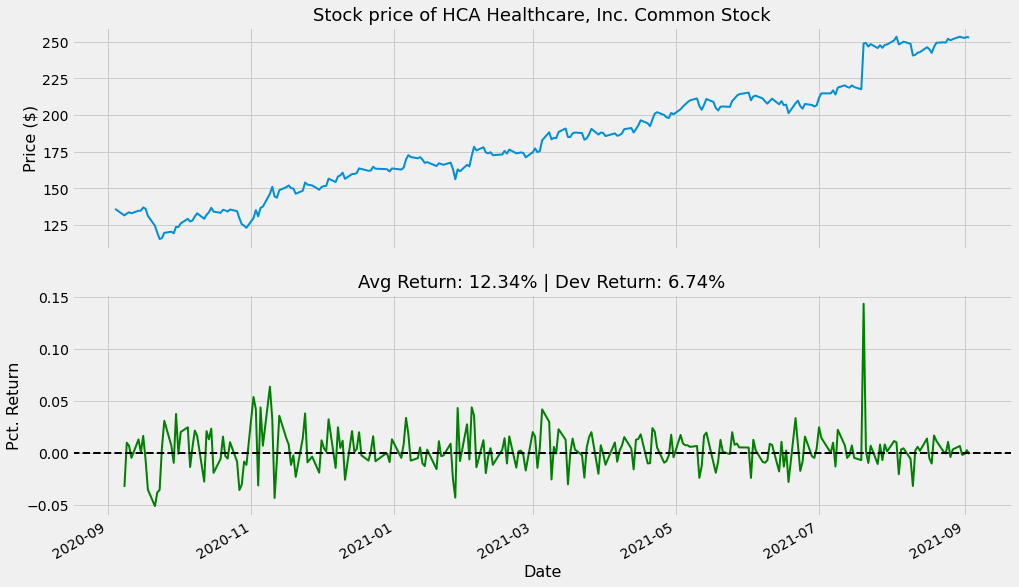

- HEI.A: No data found, symbol may be delisted
- HUGS=: No data found, symbol may be delisted
- HUGS+: No data found, symbol may be delisted
- HVT.A: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

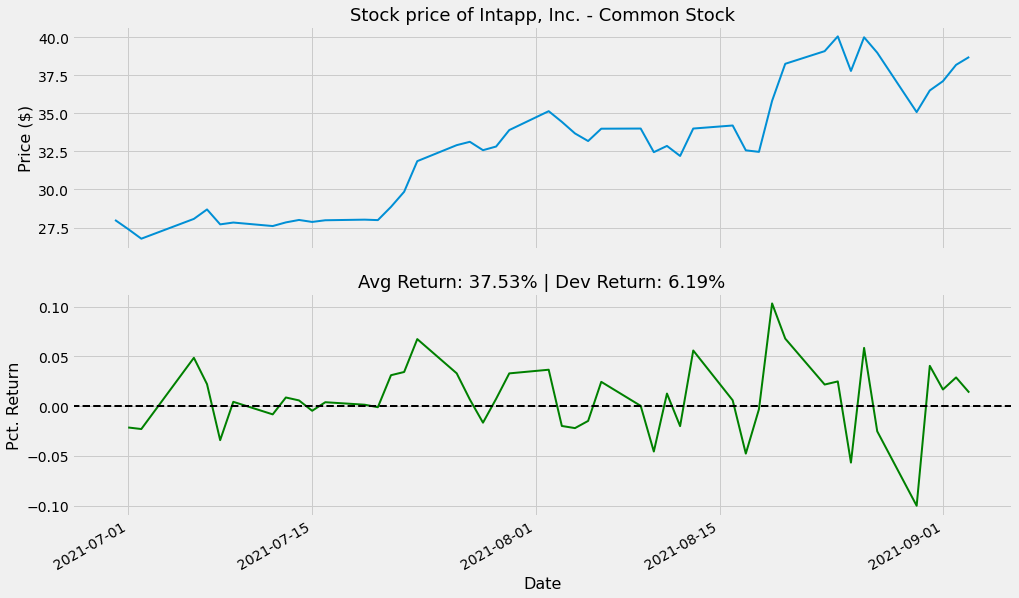

- IRNT+: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

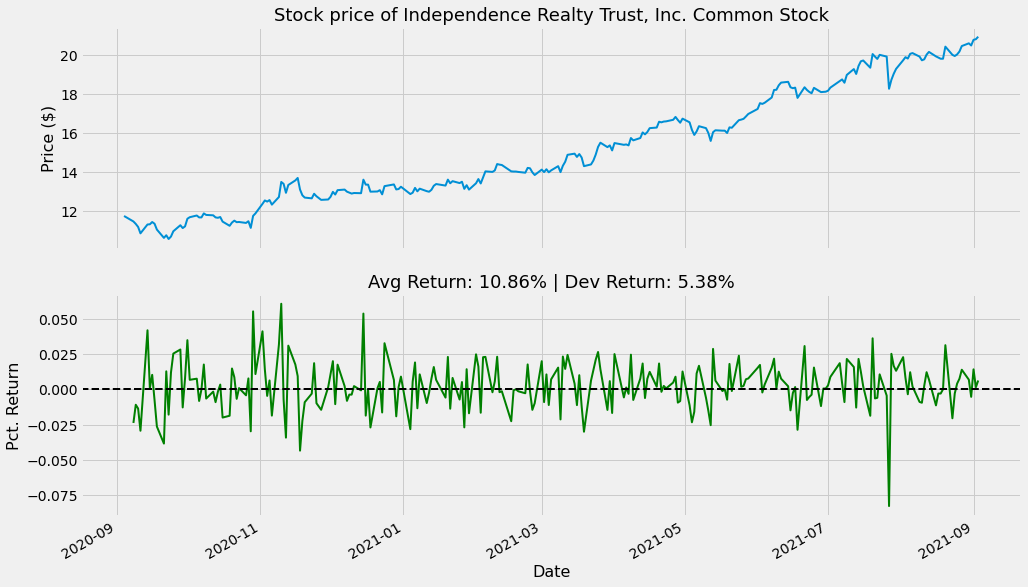

- JBI+: No data found, symbol may be delisted
- JW.A: No data found, symbol may be delisted
- JW.B: No data found, symbol may be delisted
- JXN#: No data found for this date range, symbol may be delisted
- KAHC=: No data found, symbol may be delisted
- KAHC+: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

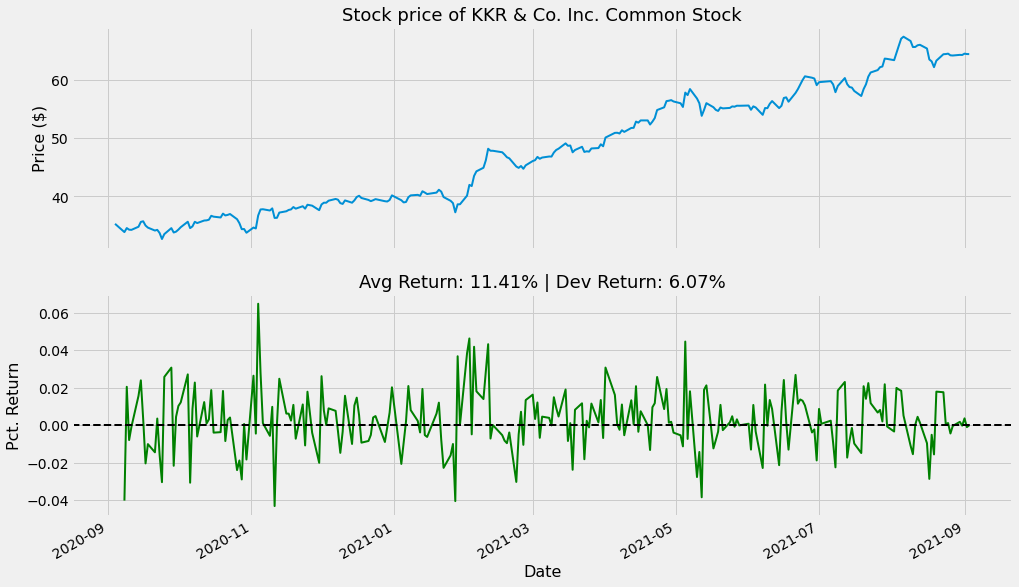

<Figure size 1080x720 with 0 Axes>

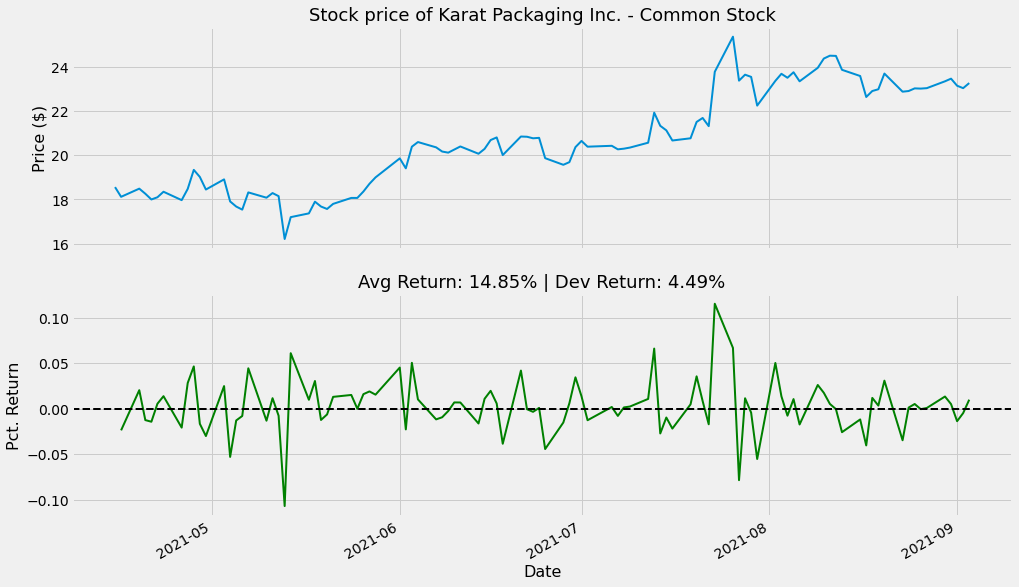

- KWAC=: No data found, symbol may be delisted
- LGV=: No data found, symbol may be delisted
- LGV+: No data found, symbol may be delisted
- LOKB+: No data found, symbol may be delisted
- MACC=: No data found, symbol may be delisted
- MACC+: No data found, symbol may be delisted
- MCY: No data found, symbol may be delisted
- MDH=: No data found, symbol may be delisted
- MKC.V: No data found, symbol may be delisted
- MOG.A: No data found, symbol may be delisted
- MOG.B: No data found, symbol may be delisted
- NTEST.C: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

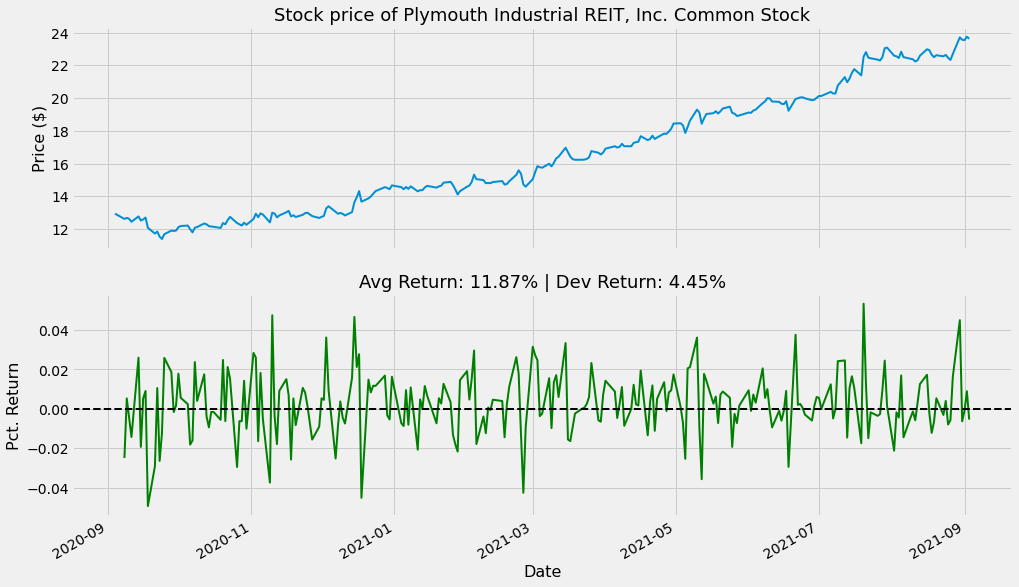

- PSTH+: No data found, symbol may be delisted
- PTK+: No data found, symbol may be delisted
- QFTA=: No data found, symbol may be delisted
- QFTA+: No data found, symbol may be delisted
- ROT=: No data found, symbol may be delisted
- ROT+: No data found, symbol may be delisted
- SBEV+: No data found, symbol may be delisted
- SBII+: No data found, symbol may be delisted
- SEAH=: No data found, symbol may be delisted
- SEAH+: No data found, symbol may be delisted
- SFTW=: No data found, symbol may be delisted
- SFTW+: No data found, symbol may be delisted
- STZ.B: No data found for this date range, symbol may be delisted
- TAP.A: No data found, symbol may be delisted
- THCP: No data found for this date range, symbol may be delisted
- VHAQ^: No data found, symbol may be delisted
- VST+A: No data found, symbol may be delisted
- WARR+: No data found, symbol may be delisted


<Figure size 1080x720 with 0 Axes>

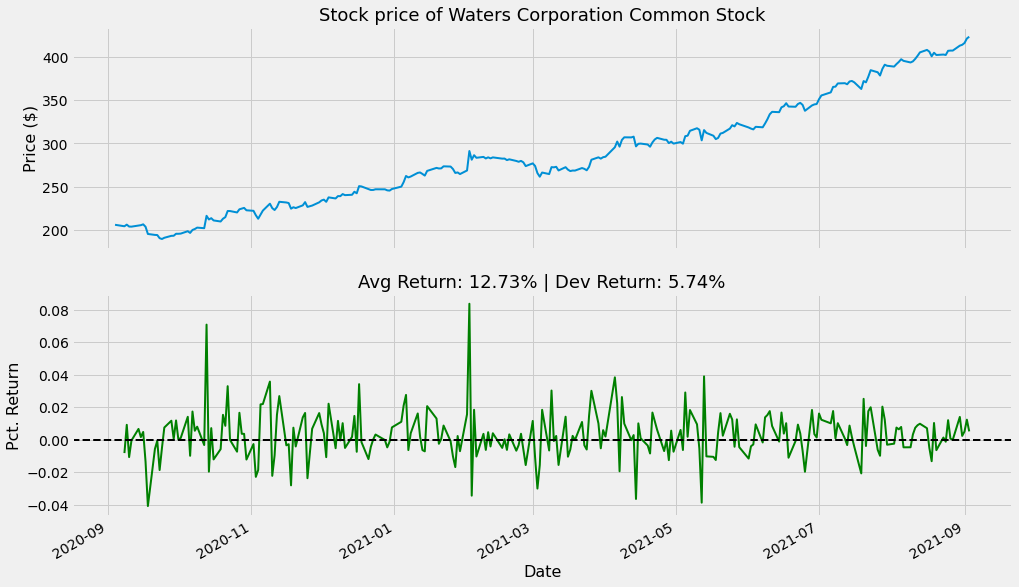

- WSO.B: No data found, symbol may be delisted
- XPOA+: No data found, symbol may be delisted
- ZXYZ.A: No data found, symbol may be delisted


In [ ]:
# Implement Functions
for ticker in nasdaq_list:
    avg_return, dev_return, all_returns = perform_analysis_for_stock(ticker, start_date, end_date, return_period_weeks)

    if avg_return > min_avg_return and dev_return < max_dev_return:
      # Define Title of Plots
      stock_name = stocks.loc[stocks["Ticker"] == ticker, "Name"].item()
      title_price = '%s/n%s'%(ticker, stock_name)
      title_return = 'Avg Return: %s%% | Dev Return: %s%%'%(round(100*avg_return,2), round(100*dev_return,2))
      plot_stock_trend_and_returns(ticker, [title_price, title_return], start_date, end_date, all_returns)